In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [3]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")


# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset_std.shape[0], Dataset_std.shape[0]/2, random_state=22)
Dataset_std_short = pd.DataFrame(Dataset_std.loc[indices.tolist()])
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])


# Checking distribution before and after shortening
print("Original Dataset Shape: ", Dataset_std.shape)
print("Reduced Dataset Shape: ", Dataset_std_short.shape)

Original Dataset Shape:  (157800, 36)
Reduced Dataset Shape:  (78900, 36)


In [4]:
# seperating Datasamples with normal and abnormal samples
Dataset_only0 = Dataset_std_short.loc[Attack_label_short['Attack_label'] == 0] # normal label
Dataset_only1 = Dataset_std_short.loc[Attack_label_short['Attack_label'] == 1] 
print("Sample shape of only normal label", Dataset_only0.shape)
print("Sample shape of only abnormal label", Dataset_only1.shape)

from sklearn.model_selection import train_test_split
X_train, array_test_0 = train_test_split(Dataset_only0, train_size=0.8, random_state=22)

Sample shape of only normal label (12152, 36)
Sample shape of only abnormal label (66748, 36)


* X_train is dataframe of only normal samples

In [5]:
# preparing the test dataset by joining some of the normal and abnormal samples.
import numpy as np

array1 = Dataset_only1.to_numpy() 

# Joining the abnormal and normal samples for testing
X_test = np.concatenate((array1, array_test_0), axis=0)
Y_test = np.concatenate((np.ones(array1.shape[0])*-1, np.ones(array_test_0.shape[0])), axis=0)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (9721, 36)
Shape of X_test:  (69179, 36)


* X_test is array of both normal and abnormal samples with huge proportion of abnormal instances.<br>
Y_test is label of 1 and -1 for the normal and abnormal instances respectively.  


## Determining Hyperparameter

Gridsearch

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(novelty=True)
param_grid = {
    'n_neighbors': [6, 10, 20],
    'leaf_size': [10, 30, 50],
    'metric': ['euclidean', 'manhattan', 'l1', 'l2', 'minkowski']
}
grid_eval = GridSearchCV(lof, param_grid, cv=3)

from sklearn.metrics import make_scorer, roc_auc_score, f1_score

def custom_scorer(y_true, y_pred):
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    return f1_score(y_true, y_pred)

scorer = make_scorer(custom_scorer, greater_is_better=True)

Y_train = np.zeros(X_train.shape[0]) # all normal samples
grid_eval = GridSearchCV(lof, param_grid, scoring=scorer, cv=2)
search_grid = grid_eval.fit(X_train, Y_train)

print("Hyperparameters: ", search_grid.best_params_)
print("Best score: ", search_grid.best_score_)

Hyperparameters:  {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 6}
Best score:  0.0285613510468155


In [8]:
# Defining the LOF model and parameters for grid search
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(novelty=True)
param_grid = {
    'n_neighbors': [10, 20],
    'leaf_size': [10, 30],
    'metric': ['euclidean', 'manhattan', 'l1', 'l2', 'minkowski']
}

# Create a mask for labeled and unlabeled data
y = np.ones(X_train.shape[0])  # Label 1 indicates labeled data
rng = np.random.RandomState(42)
random_unlabeled_points = rng.rand(X_train.shape[0]) < 0.3
y[random_unlabeled_points] = -1  # Label -1 indicates unlabeled data

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-pack

Best parameters found:  {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 10}


/home/user/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


## LOF for Novelty Detection

Novelty detection is semisupervised Outlier Detection because it uses only Normal Dataset to train.(supervised learning aspect)<br>
and during testing phase unlabeled Data are given to predict whether it is novelty/anomalie or not.<br>
Novelties/anomalies can form a dense cluster as long as they are in a low density region of the training data, which is only normal.

In [6]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=6, contamination='auto', novelty=True, metric= 'euclidean', leaf_size=10)
lof.fit(X_train)
Y_pred = lof.predict(X_test)

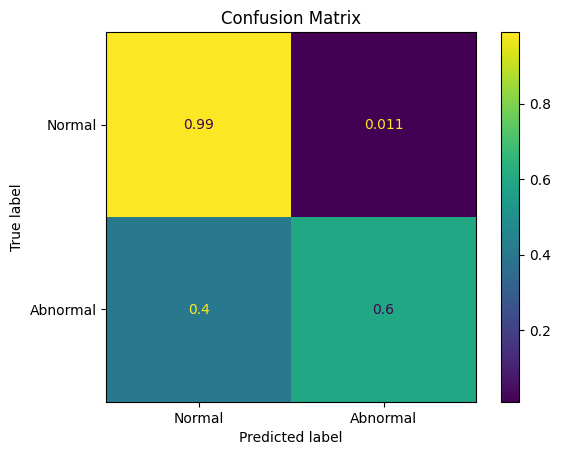

Average Accuracy Score: 0.6090287514997326
Balanced Accuracy Score: 0.7920436614841206
         Precision    Recall  F1-Score
Anomaly   0.999321  0.595194  0.746045


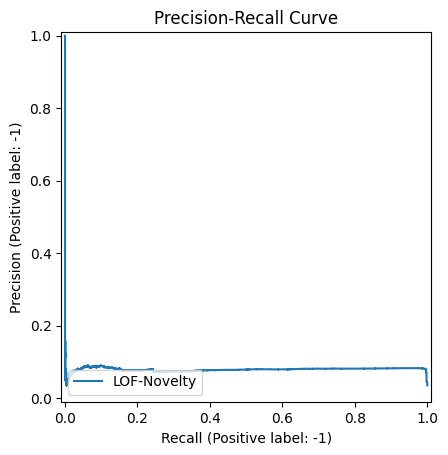

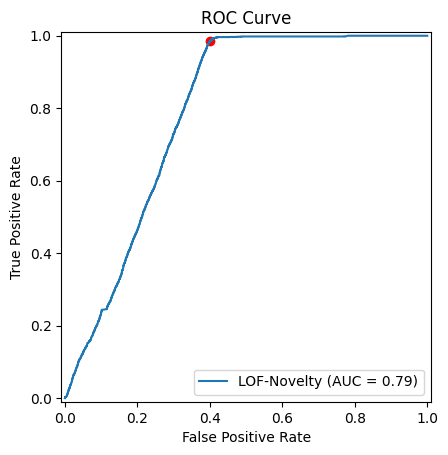

In [8]:
from sklearn import metrics
cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')   
plt.show()

print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1,labels=[-1], average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, labels=[-1], average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# FOR Prec-Recall and ROC, decision function scores are needed (not just -1 or 1 labels)
Y_scores = lof.decision_function(X_test)

#Precision-Recall Curve
prec, recall, thresh = metrics.precision_recall_curve(Y_test, Y_scores)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, pos_label= -1, estimator_name='LOF-Novelty').plot()
plt.title('Precision-Recall Curve')


fpr, tpr, thresh = metrics.roc_curve(Y_test, Y_scores)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LOF-Novelty')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve")
plt.show()


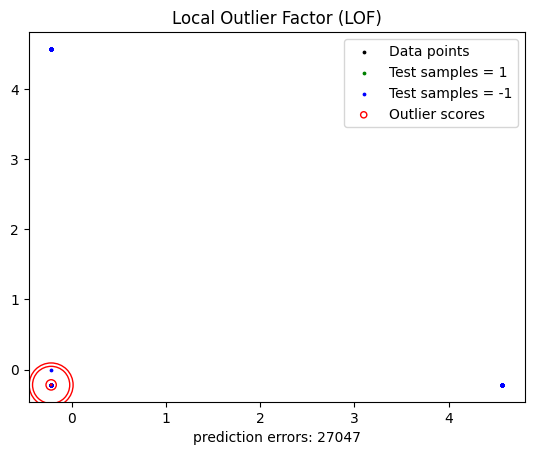

In [9]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])

X_scores = lof.negative_outlier_factor_
n_errors = (Y_pred != Y_test).sum()

plt.scatter(X_train.to_numpy()[:, 8], X_train.to_numpy()[:, 5], color="k", s=3.0, label="Data points")
plt.scatter(X_test[(Y_test == 1), 8] , X_test[(Y_test == 1), 5], color="g", s=3.0, label="Test samples = 1") # normal
plt.scatter(X_test[(Y_test == -1), 8] , X_test[(Y_test == -1), 5], color="b", s=3.0, label="Test samples = -1") # abnormal
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X_train.to_numpy()[:, 8],
    X_train.to_numpy()[:, 5],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

## LOF for Novelty Detection after PCA

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

lof.fit(X_train_PCA)
Y_pred = lof.predict(X_test_PCA)

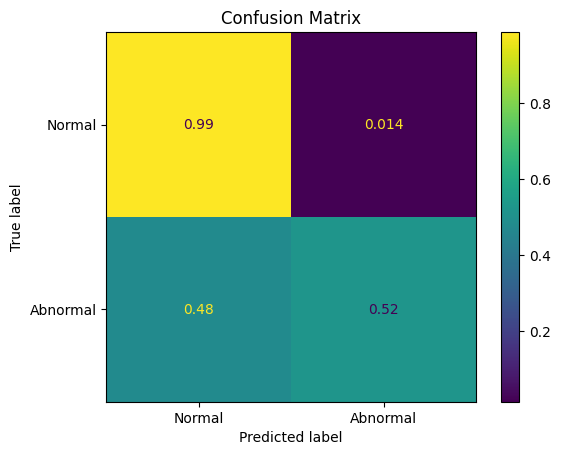

Average Accuracy Score: 0.5355960623888752
Balanced Accuracy Score: 0.752800971954487
         Precision    Recall  F1-Score
Anomaly   0.999049  0.519177  0.683275


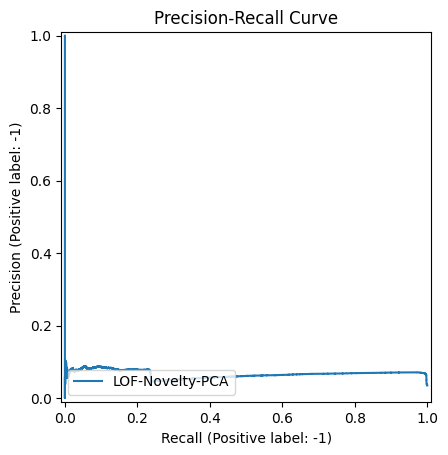

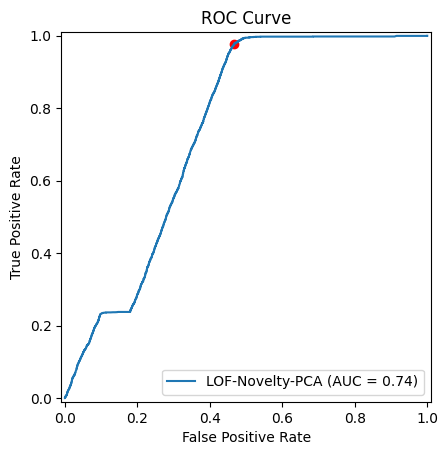

In [13]:
from sklearn import metrics
cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')   
plt.show()

print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1,labels=[-1], average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, labels=[-1], average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# FOR Prec-Recall and ROC, decision function scores are needed (not just -1 or 1 labels)
Y_scores = lof.decision_function(X_test_PCA)

#Precision-Recall Curve
prec, recall, thresh = metrics.precision_recall_curve(Y_test, Y_scores)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, pos_label= -1, estimator_name='LOF-Novelty-PCA').plot()
plt.title('Precision-Recall Curve')

fpr, tpr, thresh = metrics.roc_curve(Y_test, Y_scores)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name= 'LOF-Novelty-PCA')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve")
plt.show()


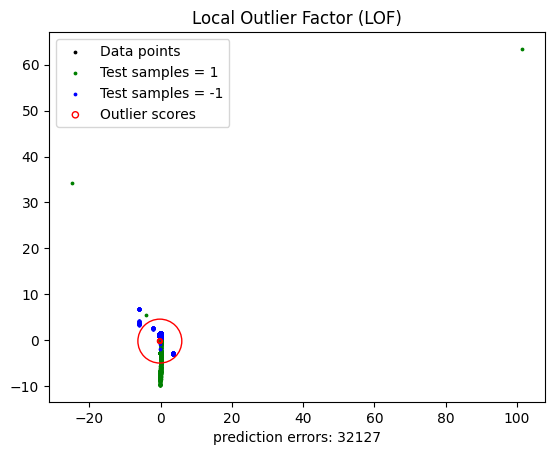

In [14]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])

X_scores = lof.negative_outlier_factor_
n_errors = (Y_pred != Y_test).sum()

plt.scatter(X_train.to_numpy()[:, 8], X_train.to_numpy()[:, 5], color="k", s=3.0, label="Data points")
plt.scatter(X_test_PCA[(Y_test == 1), 8] , X_test_PCA[(Y_test == 1), 5], color="g", s=3.0, label="Test samples = 1") # normal
plt.scatter(X_test_PCA[(Y_test == -1), 8] , X_test_PCA[(Y_test == -1), 5], color="b", s=3.0, label="Test samples = -1") # abnormal
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X_train.to_numpy()[:, 8],
    X_train.to_numpy()[:, 5],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

## LOF for Outlier Detection

LOF for Outlier Detection uses Unsupervised Learning Methods. In the context of outlier detection, outliers/anomalies cannot form a dense cluster.<br>
The estimator assume that the outliers/anomalies are located in low density regions.<br>
The training data contains outliers which are defined as observations that are far from the others.<br>
Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.

preparing Dataset

In [20]:
from sklearn.model_selection import train_test_split
array_train_0, array_test_0 = train_test_split(Dataset_only0, train_size=0.8, random_state=22)
array_train_1, array_test_1 = train_test_split(Dataset_only1, train_size=0.025, random_state=22)
print("array_train_0 shape: ", array_train_0.shape, "\narray_train_1 shape: ", array_train_1.shape)

X_train = pd.concat([array_train_0, array_train_1])
Y_train = pd.concat([pd.DataFrame([1]*array_train_0.shape[0]), pd.DataFrame([-1]*array_train_1.shape[0])])
X_test = pd.concat([array_test_0, array_test_1])
Y_test = pd.concat([pd.DataFrame([1]*array_test_0.shape[0]), pd.DataFrame([-1]*array_test_1.shape[0])]) 

array_train_0 shape:  (9721, 36) 
array_train_1 shape:  (1668, 36)


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(novelty=False, contamination=array_train_1.shape[0]/(X_train.shape[0]))
param_grid = {
    'n_neighbors': [6, 10, 20],
    'leaf_size': [10, 30, 50],
    'metric': ['euclidean', 'manhattan', 'l1', 'l2', 'minkowski']
}

grid_eval = GridSearchCV(lof, param_grid=param_grid, cv=4, scoring='roc_auc')
search_grid = grid_eval.fit(X_train, Y_train)

print("Hyperparameters: ", search_grid.best_params_)
print("Best score: ", search_grid.best_score_)

Hyperparameters:  {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 6}
Best score:  nan


In [27]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=6, contamination= array_train_1.shape[0]/(X_train.shape[0]), metric='euclidean', novelty=False)
Y_pred = lof.fit_predict(X_test)

Evaluation

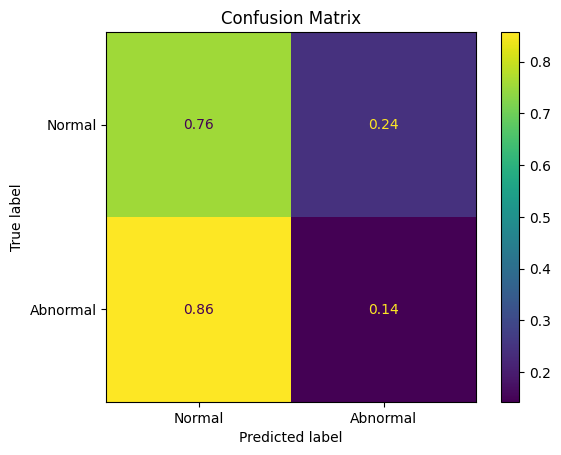

Average Accuracy Score: 0.16490645968805084
Balanced Accuracy Score: 0.44944583914946185
         Precision    Recall  F1-Score
Anomaly   0.940028  0.142824  0.247972


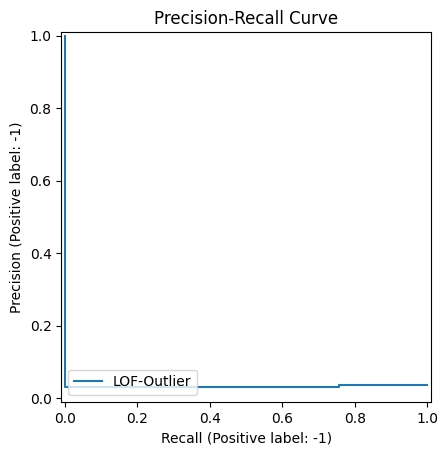

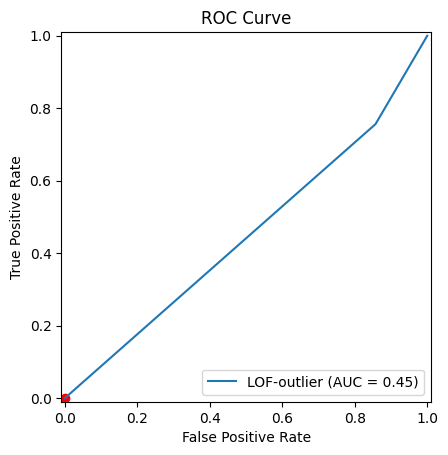

In [28]:
import numpy as np
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')   
plt.show()

print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1, labels=[-1], average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, labels=[-1], average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

#Precision-Recall Curve
prec, recall, thresh = metrics.precision_recall_curve(Y_test, Y_pred)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, pos_label= -1, estimator_name='LOF-Outlier').plot()
plt.title('Precision-Recall Curve')

# ROC Curve
fpr, tpr, thresh = metrics.roc_curve(Y_test, Y_pred)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LOF-outlier')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve")
plt.show()

PCA

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_PCA = pca.fit_transform(X_train)

## Conclusion